IMPORTS

In [1]:
# Initial imports
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [2]:
crime_df = pd.read_csv('Resources/cleaned_crime_df.csv')
crime_df.head()

,year,zip,division_id,npa,date_reported_y/m,place_detail_description,highest_nibrs_description,location_type_description,clearance_status
0,2021,28202,01,476,2021-08,Air/Bus/Train Terminal,All Other Thefts,Outdoors,Open
1,2021,28273,21,82,2021-07,Apartment/Duplex Private Res,Theft From Motor Vehicle,Parking Lot,Open
2,2017,28208,02,293,2017-05,Private Residence,Damage/Vandalism Of Property,Outdoors,Open
3,2022,28269,11,125,2022-10,Hotel/Motel,Forcible Fondling,Indoors,Open
4,2017,28215,07,271,2017-08,Private Residence,Burglary/B&E,Indoors,Open


In [3]:
# Define categorical features to be one-hot encoded
categorical_features = ['zip', 'division_id', 'date_reported_y/m', 'place_detail_description', 'highest_nibrs_description', 'location_type_description']

# Fill NaN values with 'missing' for categorical features using .loc
crime_df.loc[:, categorical_features] = crime_df.loc[:, categorical_features].fillna('missing')

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the categorical features
encoded_features = encoder.fit_transform(crime_df[categorical_features])

# Convert encoded features to DataFrame
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Ensure the index matches
encoded_features_df.index = crime_df.index

# Concatenate the encoded features with the original DataFrame (dropping the original categorical columns)
final_encoded_df = pd.concat([crime_df.drop(columns=categorical_features), encoded_features_df], axis=1)

# Label encode the target variable
label_encoder = LabelEncoder()
final_encoded_df['clearance_status'] = label_encoder.fit_transform(crime_df['clearance_status'])

# Save the prepared DataFrame to a new CSV file
#final_encoded_df.to_csv('Resources/encoded_crime_data.csv', index=False) 

In [4]:
# Separate the target variable, y
y = final_encoded_df['clearance_status']

# Separate the features, X, and drop unnecessary columns
X = final_encoded_df.drop(columns=['clearance_status'])

# Print a preview of both
print(y[:5])
print(X.head())

0    1
1    1
2    1
3    1
4    1
Name: clearance_status, dtype: int32
   year  npa  zip_28203  zip_28204  zip_28205  zip_28206  zip_28207  \
0  2021  476        0.0        0.0        0.0        0.0        0.0   
1  2021   82        0.0        0.0        0.0        0.0        0.0   
2  2017  293        0.0        0.0        0.0        0.0        0.0   
3  2022  125        0.0        0.0        0.0        0.0        0.0   
4  2017  271        0.0        0.0        0.0        0.0        0.0   

   zip_28208  zip_28209  zip_28210  ...  \
0        0.0        0.0        0.0  ...   
1        0.0        0.0        0.0  ...   
2        1.0        0.0        0.0  ...   
3        0.0        0.0        0.0  ...   
4        0.0        0.0        0.0  ...   

   highest_nibrs_description_Theft From Coin-Operated Machine Or Device  \
0                                                0.0                      
1                                                0.0                      
2                

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = scaler.transform(X_test)

In [6]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [7]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [8]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [9]:
print(predictions)

[1 1 1 ... 0 1 1]


In [10]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
unique_classes = sorted(list(set(y_test)))
cm_df = pd.DataFrame(
    cm, index=[f"Actual {cls}" for cls in unique_classes], columns=[f"Predicted {cls}" for cls in unique_classes]
)

# display confusion matrix DF
print(cm_df.head())

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {acc_score}")

          Predicted 0  Predicted 1
Actual 0        13600        12189
Actual 1         6529        59543
Accuracy Score: 0.7962356168559018


In [11]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13600,12189
Actual 1,6529,59543


Accuracy Score : 0.7962356168559018
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.53      0.59     25789
           1       0.83      0.90      0.86     66072

    accuracy                           0.80     91861
   macro avg       0.75      0.71      0.73     91861
weighted avg       0.79      0.80      0.79     91861



In [12]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.13619103134069752, 'npa'),
 (0.05947751906346322, 'highest_nibrs_description_Drug/Narcotic Violations'),
 (0.04728247637201426, 'highest_nibrs_description_Simple Assault'),
 (0.042528520012726355, 'year'),
 (0.02642280929409641, 'highest_nibrs_description_Theft From Motor Vehicle'),
 (0.018297680976234677, 'highest_nibrs_description_All Other Thefts'),
 (0.014758802925189395, 'location_type_description_Outdoors'),
 (0.013795701191494474, 'highest_nibrs_description_Stolen Property Offenses'),
 (0.0112603095732103, 'highest_nibrs_description_Trespass Of Real Property'),
 (0.010881322179386433, 'highest_nibrs_description_All Other Offenses'),
 (0.010621554608910016, 'location_type_description_Parking Lot'),
 (0.01006494548943777, 'highest_nibrs_description_Drug Equipment Violations'),
 (0.009735824486504662,
  'highest_nibrs_description_Driving Under The Influence'),
 (0.009663108600505097, 'place_detail_description_Private Residence'),
 (0.00944482048098732,
  'place_detail_descripti

<Axes: title={'center': 'Top 20 Feature Importances'}, ylabel='Feature'>

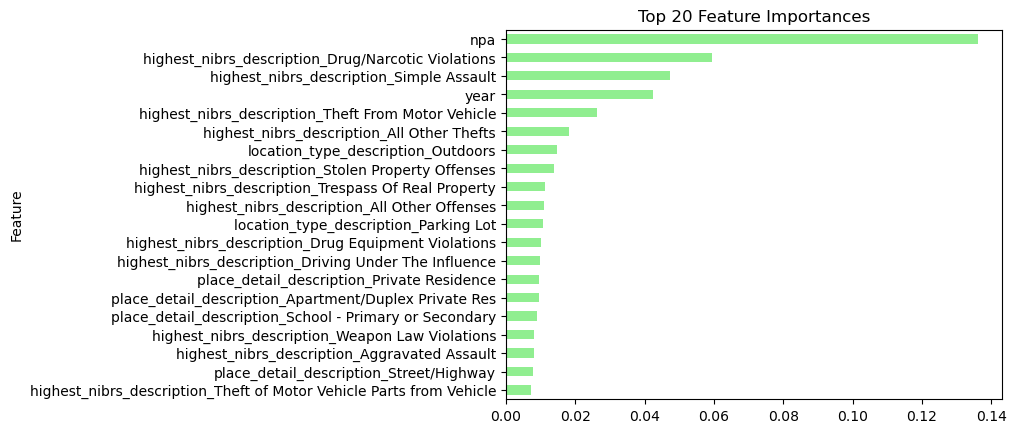

In [13]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True), columns=['Feature Importances', 'Feature'])
importances_df.set_index('Feature', inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
top_20_importances = importances_sorted.head(20)
top_20_importances.sort_values(by='Feature Importances').plot(kind='barh', color='lightgreen', title='Top 20 Feature Importances', legend=False)
